In [1]:
import urllib3
import httplib2
import re
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen as ureq
from urllib.parse import quote  

import sqlite3

import pandas as pd

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time


In [2]:
uclient=ureq('https://www.banggood.in/search/mobile-phone/0-0-0-1-1-60-0-price-0-0_p-3.html')
page_html=uclient.read()
uclient.close()
page_soup=BeautifulSoup(page_html,"html")

    

In [ ]:
# column headers : 
# Name | price | old price | %off | reviews

In [23]:
print(page_soup)

<!DOCTYPE html>

<html lang="en" xmlns="http://www.w3.org/1999/xhtml">
<head>
<meta content="no-referrer-when-downgrade" name="referrer"/>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<link href="https://www.banggood.in/search/mobile-phone.html" rel="canonical"/>
<title>mobile phone - Buy mobile phone with free shipping | Banggood Shopping India</title>
<meta content="Buy the best and latest mobile phone on banggood.com offer the quality mobile phone on sale with worldwide free shipping. | Shopping India" name="description"/>
<meta content="4p71n-uarrm9rds-9o6rtwu2tffleogqmwmcv15qn5gclx6p534xcr8u-ch3mqrjfauohaqw7-j52svb294owid-3xd4lwvqbo4mdt9c5140m1uylbk-zcotf98i5cf8" name="norton-safeweb-site-verification"/>
<meta content="mobile phone, Wholesale mobile phone , Dropship mobile phone" name="keywords"/>
<meta content="noindex,nofollow" name="robots"/>
<meta content="no" http-equiv="imagetoolbar"/>
<meta content="Banggood.com" name="author"/>
<meta content="100003

In [3]:
cards = page_soup.find_all("div", class_="p-wrap")
print(len(cards))

60


In [27]:
sql_buffer = []

In [25]:
def fuck_this_shit():
    sql_buffer.append("🐥")

In [26]:
fuck_this_shit()
print(sql_buffer)

['🐥']


In [69]:
# List for colum headers, this is the features that will be extracted for each product
lis_headers = ["Name", "Price", "Old Price", "Percent off", "Reviews", "Rating Total", "5 stars", "4 stars", "3 stars", "2 Stars", "1 Star"]   
# lis_headers = ["Name", "Price", "Old Price", "Percent off", "Reviews"]   
#                  0         1       2             3             4            5            6          7           8          9         10
lis_data = [list() for i in range(len(lis_headers))]     

sql_buffer = []
count = 0
product_name = "mobile phones"
connection = sqlite3.connect(f"{product_name}.db")
cursor = connection.cursor()

commit_at = 20
print(len(lis_data))
print(len(lis_headers))


# def clean_product_name(name):
#     name = strip(name)
#     for char in name:
#         if char == " ":
            

def transaction(sql):
    global sql_buffer
    sql_buffer.append(sql)   # DOUBT!!!!
    if len(sql_buffer) >= commit_at:
        print("Starting transaction!")
        cursor.execute("BEGIN TRANSACTION")
        for query in sql_buffer:
            try:
                cursor.execute(query)
            except Exception as e:
                print(e)
        connection.commit()
        print("Commit successful!")
        sql_buffer = []


def create_table():
    cursor.execute("CREATE TABLE IF NOT EXISTS product_table(prod_name VARCHAR(500), price FLOAT, old_price FLOAT, percent_off INT(3), reviews INT(6), rating_total FLOAT, stars_5 INT(5), stars_4 INT(5), stars_3 INT(5), stars_2 INT(5), stars_1 INT(5))")


def get_page_soup(url):
    uclient=ureq(httplib2.iri2uri(url))
    page_html=uclient.read()
    uclient.close()
    return BeautifulSoup(page_html,"html")

def scrape(page_soup):
    global count
    cards = page_soup.find_all("div", class_="p-wrap")
    for card in cards:
        print("Card: ",cards.index(card))
        try:                                    # Try to get the Name and reviews of the product
            a = card.find_all("a")
            try:
                lis_data[0].append(a[1].text)   # Name
            except Exception as e:
                lis_data[0].append("NaN")       # write nan if not found
            try:
                lis_data[4].append(int(a[2].text[:-8]))  # review
            except Exception as e:
                lis_data[4].append("NaN")
        except Exception as e:
            lis_data[0].append("NaN")           # 'Nan' for both name and review if finding the 'a' tag fails
            lis_data[4].append("NaN")
        try:                                    # Try to find price
            price = card.find("span", class_="price-box")
            pattern = re.compile(r"\n+(.*?)\n")
            matches = pattern.findall(price.text)      
            price = matches[0][1:].split(",")
            price_final = ""
            for i in price:
                price_final += i
            lis_data[1].append(float(price_final))
        except Exception as e:
            lis_data[1].append("Nan")
        try:
            price_old = card.find("span", class_="price-old-box")
            spans = price_old.find_all("span")
            try:
                price = spans[0].text[1:].split(",")
                price_final = ""
                for i in price:
                    price_final += i                
                lis_data[2].append(float(price_final))   # Old Price ---- spans[0].text
            except Exception as e:
                lis_data[2].append("NaN")        
            try:
                lis_data[3].append(int(spans[1].text[:-5]))       # % off ----- spans[1].text
            except Exception as e:                
                lis_data[3].append("NaN")
        except Exception as e:
                lis_data[2].append("NaN")        
                lis_data[3].append("NaN")
        scrape_stars(card)
        check_null = lambda x:"NULL" if x == "NaN" else x
        query = f"INSERT INTO product_table (prod_name, price, old_price, percent_off, reviews, rating_total, stars_5, stars_4, stars_3, stars_2, stars_1) VALUES ('{check_null(lis_data[0][count])}', {check_null(lis_data[1][count])}, {check_null(lis_data[2][count])}, {check_null(lis_data[3][count])}, {check_null(lis_data[4][count])}, {check_null(lis_data[5][count])}, {check_null(lis_data[6][count])}, {check_null(lis_data[7][count])}, {check_null(lis_data[8][count])}, {check_null(lis_data[9][count])}, {check_null(lis_data[10][count])})"
        transaction(query)
        print(query)
        count += 1
        # break
        

def scrape_stars(card):
    review_link = card.find("a", class_="review", href=True)
    # print(review_link['href'])
    stars_soup = get_page_soup(review_link['href'])
    rev_score = stars_soup.find("div", class_="rev-score")
    try:
        lis_data[5].append(float(rev_score.find("div", class_="score").text[:-9]))
    except Exception as e:
        lis_data[5].append("NaN")
    try:
        stars = stars_soup.find_all("a", class_="star")
        try:
            star = stars[0].find("span", class_="histogram-count").text
            lis_data[6].append(int(star.split(" ")[0])) # 5 star
        except Exception as e:
            lis_data[6].append("NaN") 
        try:
            star = stars[1].find("span", class_="histogram-count").text
            lis_data[7].append(int(star.split(" ")[0])) # 4 star
        except Exception as e:
            lis_data[7].append("NaN") 
        try:
            star = stars[2].find("span", class_="histogram-count").text
            lis_data[8].append(int(star.split(" ")[0])) # 3 star
        except Exception as e:
            lis_data[8].append("NaN") 
        try:
            star = stars[3].find("span", class_="histogram-count").text
            lis_data[9].append(int(star.split(" ")[0])) # 2 star
        except Exception as e:
            lis_data[9].append("NaN") 
        try:
            star = stars[4].find("span", class_="histogram-count").text
            lis_data[10].append(int(star.split(" ")[0])) # 1 star
        except Exception as e:
            lis_data[10].append("NaN") 
    except Exception as e:
        for i in range(6,11):
            lis_data[i].append("NaN")        

            
     


create_table()
current_page = 1
url = f"https://www.banggood.in/search/mobile-phone/0-0-0-1-1-60-0-price-0-0_p-{current_page}.html"
total_pages = get_page_soup(url).find("div", class_="total")
pages = total_pages.text
pages = int(pages[6:8])

for page in range(1,pages):
    url = f"https://www.banggood.in/search/mobile-phone/0-0-0-1-1-60-0-price-0-0_p-{page}.html"
    # print(url)
    scrape(get_page_soup(url)) 
# df = pd.DataFrame(lis_data, columns=["Name", "Price", "Old Price", "Percent off", "Reviews"])
m_dic = {"Name":lis_data[0], "Price":lis_data[1], "Old Price":lis_data[2], "Percent Off":lis_data[3], "reviews":lis_data[4], "Rating Total":lis_data[5], "5 stars":lis_data[6], "4 stars":lis_data[7], "3 stars":lis_data[8], "2 stars":lis_data[9], "1 star":lis_data[10] }
df = pd.DataFrame(m_dic)
connection.close()


11
11
Card:  0
INSERT INTO product_table (prod_name, price, old_price, percent_off, reviews, rating_total, stars_5, stars_4, stars_3, stars_2, stars_1) VALUES ('SOYES XS11 3G Mini Smart Android With WIFI Phone 2.5 Inch 1000mAh GPS RAM 1GB ROM 8GB Quad Core Google Play Facebook Whatsapp Mobile Phone', 4515.39, 5719.69, 21, 16, 4.8, 13, 1, 1, 0, 0)
Card:  1
INSERT INTO product_table (prod_name, price, old_price, percent_off, reviews, rating_total, stars_5, stars_4, stars_3, stars_2, stars_1) VALUES ('Baseus Lazy Holder for Bed Desk Desktop Office Kitchen Phone Holder Long Arm Flexible Mobile Phone Stand Holder Tablet Clip Bracket for Smart Phone Tablet', 2257.32, 3235.81, 30, 19, 4.95, 18, 1, 0, 0, 0)
Card:  2
INSERT INTO product_table (prod_name, price, old_price, percent_off, reviews, rating_total, stars_5, stars_4, stars_3, stars_2, stars_1) VALUES ('KUH 2.6'' 13800mah Torch Big Speaker Big Screen Mobile Phones Long Standby Feature Phone', 2218.18, 3010.01, 26, 12, 4.83, 10, 2, 0, 0, 

In [64]:
check_null = lambda x:"NULL" if x == "NaN" else x
check_null(46.7)

46.7

In [65]:
create_table()

In [12]:
cursor.execute("SELECT * FROM product_table")

In [28]:
df.dtypes

Name             object
Price           float64
Old Price       float64
Percent Off       int64
reviews           int64
Rating Total    float64
5 stars           int64
4 stars           int64
3 stars           int64
2 stars           int64
1 star            int64
dtype: object

In [48]:
df.tail(40)

,Name,Price,Old Price,Percent Off,reviews,Rating Total,5 stars,4 stars,3 stars,2 stars,1 star
0,SOYES XS11 3G Mini Smart Android With WIFI Pho...,4515.39,5719.69,21,16,4.8,13,1,1,0,0
1,Universal Lazy Phone Clip Stand Holder Arm Fle...,473.44,902.48,48,5,5.0,5,0,0,0,0
2,BOYA BY-MM1 Video Record Microphone+STARTRC Fi...,2784.20,3461.62,20,NaN,0.0,0,0,0,0,0


In [57]:
for i in lis_data:
    print(lis_headers[lis_data.index(i)])
    print(i)

Name
['SOYES XS11 3G Mini Smart Android With WIFI Phone 2.5 Inch 1000mAh GPS RAM 1GB ROM 8GB Quad Core Google Play Facebook Whatsapp Mobile Phone', 'SOYES XS11 3G Mini Smart Android With WIFI Phone 2.5 Inch 1000mAh GPS RAM 1GB ROM 8GB Quad Core Google Play Facebook Whatsapp Mobile Phone', 'SOYES XS11 3G Mini Smart Android With WIFI Phone 2.5 Inch 1000mAh GPS RAM 1GB ROM 8GB Quad Core Google Play Facebook Whatsapp Mobile Phone', 'Andonstar ADSM302 Long Object Distance Digital USB Microscope For Mobile Phone Repair Soldering Tool']
Price
['₹4,562.27', '₹4,562.27', '₹4,562.27', '₹22,012.06']
Old Price
['₹5,779.08', '₹5,779.08', '₹5,779.08', '₹24,207.64']
Percent off
['21% Off', '21% Off', '21% Off', '9% Off']
Reviews
['16 reviews', '16 reviews', '16 reviews', '136 reviews']
Rating Total
[]
Rating Total
[]
Rating Total
[]
Rating Total
[]
Rating Total
[]
Rating Total
[]


In [27]:
string = "SOYES XS11 3G Mini Smart Android With WIFI Phone 2.5 Inch 1000mAh GPS RAM 1GB ROM 8GB Quad Core Google Play Facebook Whatsapp Mobile Phone"
print(len(string))

138


In [32]:
for i in range(6,11):
    print(i)

6
7
8
9
10


In [31]:
card = cards[0]
review_link = card.find("a", class_="review", href=True)
print(review_link['href'])
stars_soup = get_page_soup(review_link['href'])

rev_score = stars_soup.find("div", class_="rev-score")


out_of = int(rev_score.find("div", class_="score").text[:-9])
print(out_of)



stars = stars_soup.find_all("a", class_="star")

for star in stars:
    # print(star.find("span", class_="star-txt").text)
    print(star.find("span", class_="histogram-count").text)
    # break
print(stars[0].find("span", class_="histogram-count").text)

https://www.banggood.in/USB2_0-2-in-1-Card-Reader-SD-TF-Memory-Card-Compact-Multi-functional-Plastic-Card-Reader-for-Camera-Mobile-Phone-Tablet-reviews-p1740262.html
5
2 (100.0%)
0 (0%)
0 (0%)
0 (0%)
0 (0%)
2 (100.0%)


In [84]:
total_pages = page_soup.find("div", class_="total")
pages = total_pages.text
pages = int(pages[6:8])
pages

38

In [71]:
card = cards[1]
title = card.find_all("a")
for a in title:
    print(a.text)
price = card.find("span", class_="price-box")
print(price.text)

pattern = re.compile(r"\n+(.*?)\n")
matches = pattern.findall(price.text)

print("match: ", matches[0])

price_old = card.find("span", class_="price-old-box")
spans = price_old.find_all("span")
print(spans[0].text)
print(spans[1].text)




Baseus Lazy Holder for Bed Desk Desktop Office Kitchen Phone Holder Long Arm Flexible Mobile Phone Stand Holder Tablet Clip Bracket for Smart Phone Tablet
15 reviews


₹2,283.90

match:  ₹2,283.90
₹3,273.92
30% Off


In [45]:
title[2].text

'13 reviews'

<html xmlns="http://www.w3.org/1999/xhtml" lang="en"><head><script src="https://s.yimg.com/wi/ytc.js" async=""></script><script type="text/javascript" async="" src="https://banggoodcom.push.world/https.embed.js"></script><script async="" src="https://s.pinimg.com/ct/lib/main.d71a97dd.js"></script>
    <meta name="referrer" content="no-referrer-when-downgrade">
<meta http-equiv="Content-Type" content="text/html; charset=utf-8">
<link rel="canonical" href="https://www.banggood.in/SOYES-XS11-3G-Mini-Smart-Android-With-WIFI-Phone-2_5-Inch-1000mAh-GPS-RAM-1GB-ROM-8GB-Quad-Core-Google-Play-Facebook-Whatsapp-Mobile-Phone-p-1740889.html">
<title>Soyes xs11 3g mini smart android with wifi phone 2.5 inch 1000mah gps ram 1gb rom 8gb quad core google play facebook whatsapp mobile phone Sale - Banggood.com | Shopping India</title>
<meta itemprop="name" content="SOYES XS11 3G Mini Smart Android With WIFI Phone 2.5 Inch 1000mAh GPS RAM 1GB ROM 8GB Quad Core Google Play Facebook Whatsapp Mobile Phone&
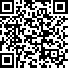
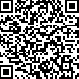

In [97]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
browser = webdriver.Chrome()

browser.get("https://www.banggood.in/SOYES-XS11-3G-Mini-Smart-Android-With-WIFI-Phone-2_5-Inch-1000mAh-GPS-RAM-1GB-ROM-8GB-Quad-Core-Google-Play-Facebook-Whatsapp-Mobile-Phone-p-1740889.html?rmmds=search&ID=6287845&cur_warehouse=CN")
elem = browser.find_element_by_tag_name("body")
no_of_pagedowns = 100

while no_of_pagedowns:
    elem.send_keys(Keys.PAGE_DOWN)
    # time.sleep(0.2)
    no_of_pagedowns-=1


html = browser.page_source
print(html)

In [98]:
review_soup = BeautifulSoup(html,"html")

In [105]:
rev_score = review_soup.find("div", class_="rev_score")
score = rev_score.find("span", class_="numbers")
print(score.text)
reviews_total = rev_score.find("a")
print(reviews_total.text)

stars = review_soup.find_all("a", class_="star")
for star in stars:
    print(star.find("span", class_="star_txt").text)
    print(star.find("span", class_="histogram_count").text)

4.79
See all 14 reviews
5 star
12 (85.7%)
4 star
1 (7.1%)
3 star
1 (7.1%)
2 star
0 (0.0%)
1 star
0 (0.0%)
